# Predicting Genre based on Spotify Track Audio Features

Spotify is one of several companies using the Music Genome Project to classify songs in order to better offer predictions to users. 
In doing this, they have labeled many of their songs with genre labels, and a number of other features including "dancebility", "tempo", "loudness", and "speechiness", to name a few. 

We here gather a sample of songs across many of the Spotify genres, and attempt to classify the genre of the songs based on their audio features.

## Scraping the data

In order to scrape the data from the Spotify API, we use the python package Spotipy, which automates creating the individual API calls. 
We used the following code to scrape the Spotify API in a seperate python script, but have included it here for convience of readers.  
Note that we set the variable scrape equal to False to avoid scraping the data in this notebook. 

Furthermore, note that in order to run the code below, a personal Spotify client ID and secret key is required. 
Since making ours public would violate the API guidlines, we have removed them in the code below.

After scraping batches of genres, we consolidated all of the batches with the following code:

## Final data cleaning

In [3]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from itertools import combinations
from matplotlib import pyplot as plt
%matplotlib inline

We first load the dataset of song features, which by construction contains precisely the features we desire. However, we do have 38 Nans in our dataset from missing data, so we simply drop these samples.

In [4]:
df = pd.read_csv("spotify_songs_info.csv")
print np.shape(df)
df = df.dropna()
print np.shape(df)
df = df.rename(columns={'id':'ID_'})

(125197, 19)
(125159, 19)


We here print the first entry of the data as an example. Note that the bulk of the columns are the audio features, followed by the genre, artist, and track names.

In [5]:
df[:5]

,Unnamed: 0,Unnamed: 0.1,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,ID_,duration_ms,time_signature,genre,artist,track
0,0,0,0.321,0.377,10.0,-7.385,1.0,0.0361,0.45400,0.0,0.3380,0.355,119.483,550rQQCGkrTzvp4SfpOPzx,268960.0,4.0,Acappella,Pentatonix,Hallelujah
1,1,1,0.497,0.312,11.0,-9.088,0.0,0.0269,0.30200,0.0,0.0968,0.179,105.036,4z8sz6E4YyFuEkv5o7IJni,203373.0,4.0,Acappella,Pentatonix,"Mary, Did You Know?"
2,2,2,0.717,0.621,11.0,-7.588,0.0,0.0605,0.00403,0.0,0.1440,0.721,133.014,6ukvsBzq4d1vBsAUmz7ZVt,248560.0,4.0,Acappella,Pentatonix,Daft Punk
3,3,3,0.730,0.433,2.0,-7.050,1.0,0.0455,0.08490,0.0,0.1690,0.574,94.596,1klGbW5a9qTBFUjFfddbmU,173053.0,4.0,Acappella,Pentatonix,Can't Sleep Love
4,4,4,0.717,0.604,7.0,-5.700,1.0,0.0594,0.13200,0.0,0.0632,0.837,111.008,6o94nmp72lGvcFfaF6dsjZ,215933.0,4.0,Acappella,Pentatonix,"O Come, All Ye Faithful"


Note that in compiling our DataFrame while scraping the data, we erronously added two additional unneccesary indexes, in the Unnamed columns. We now drop these columns:

In [6]:
feature_cols = ['danceability','energy','key','loudness',
                'mode','speechiness','acousticness',
                'instrumentalness','liveness','valence',
                'tempo','ID_','duration_ms','time_signature']
general_cols = ['genre','artist','track']
df = df[feature_cols+general_cols]
df[:5]

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,ID_,duration_ms,time_signature,genre,artist,track
0,0.321,0.377,10.0,-7.385,1.0,0.0361,0.45400,0.0,0.3380,0.355,119.483,550rQQCGkrTzvp4SfpOPzx,268960.0,4.0,Acappella,Pentatonix,Hallelujah
1,0.497,0.312,11.0,-9.088,0.0,0.0269,0.30200,0.0,0.0968,0.179,105.036,4z8sz6E4YyFuEkv5o7IJni,203373.0,4.0,Acappella,Pentatonix,"Mary, Did You Know?"
2,0.717,0.621,11.0,-7.588,0.0,0.0605,0.00403,0.0,0.1440,0.721,133.014,6ukvsBzq4d1vBsAUmz7ZVt,248560.0,4.0,Acappella,Pentatonix,Daft Punk
3,0.730,0.433,2.0,-7.050,1.0,0.0455,0.08490,0.0,0.1690,0.574,94.596,1klGbW5a9qTBFUjFfddbmU,173053.0,4.0,Acappella,Pentatonix,Can't Sleep Love
4,0.717,0.604,7.0,-5.700,1.0,0.0594,0.13200,0.0,0.0632,0.837,111.008,6o94nmp72lGvcFfaF6dsjZ,215933.0,4.0,Acappella,Pentatonix,"O Come, All Ye Faithful"


Now note that not all Spotify songs have been labeled.
Furthermore, some genres have been recently identified and have not yet had tracks assigned to them.
When we scraped the data, we skipped any genres that did not return songs for our search criteria.
Consequently, we only have data for 286 genres, and some genres may have fewer samples than others, as seen with the code below:

In [7]:
print "There are", np.shape(df['genre'].value_counts())[0], "genres in our dataset."
df['genre'].value_counts()

There are 286 genres in our dataset.


Garage Punk            500
Math Rock              500
Jangle Pop             500
Glitch                 500
Twee Pop               500
Power Metal            500
Space Rock             500
C-86                   500
Psychobilly            500
Neo-Classical Metal    500
Contemporary Folk      500
Doom Metal             500
Louisiana Blues        500
New Romantic           500
Grindcore              500
Funk                   500
Hardcore Punk          500
Indie Pop              500
Hard Rock              500
Acid Jazz              500
Downtempo              499
Merseybeat             499
Motown                 499
Freestyle              499
Swamp Blues            499
Trip-Hop               499
Synth Pop              499
Oi!                    499
Western Swing          499
Rap-Metal              499
                      ... 
Cajun                  324
Big Beat               318
Girl Group             315
Screamo                310
Jazz Blues             308
Skiffle                303
S

Thus, since the number of tracks per genre is nearly uniform (the vast majority of genres have over 300 tracks), the  base accuracy from randomly classifying genres is approximately $1/286=.0035$.

We are now prepared to analyze the data.

## Analyzing the Data

### Global Patterns

We begin our analysis of the data by exploring the patterns which exist in the aggregate of the song data. 
This global analysis will inform our later analysis of patterns more specific to families of genres.

Since the scope of this project does not permit a thorough analysis of all audio feature correlations, we begin by plotting feature columns against each other to determine the most likely correlations.

After plotting all 136 possible combinations, we find that the strongest correlations appear to lie between 
- danceability and energy
- danceability and valence
- danceability and tempo
- energy and loudness

These correlations are plotted below with hexbins. Since plotting the x-label using Pandas in the Jupyter Notebook is currently a GitHub issue, we print the x-label below each plot for convenience.

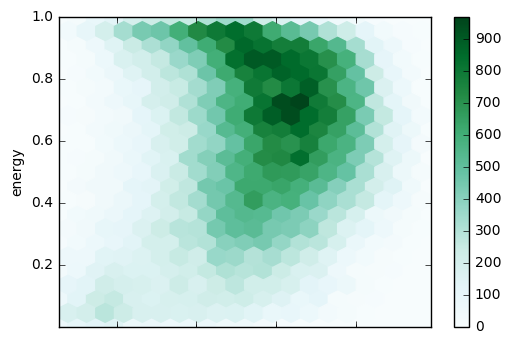

x-label: danceability


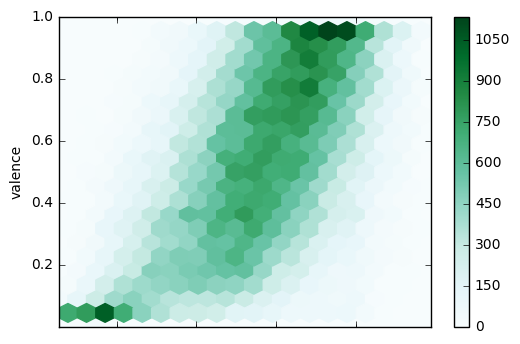

x-label: danceability


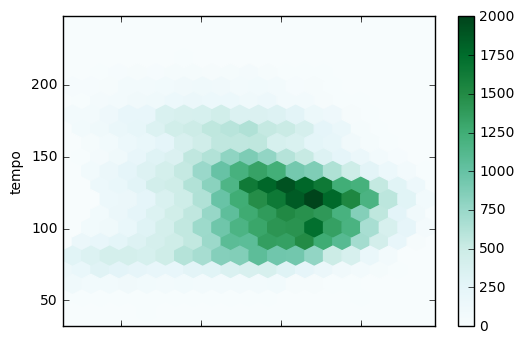

x-label: danceability


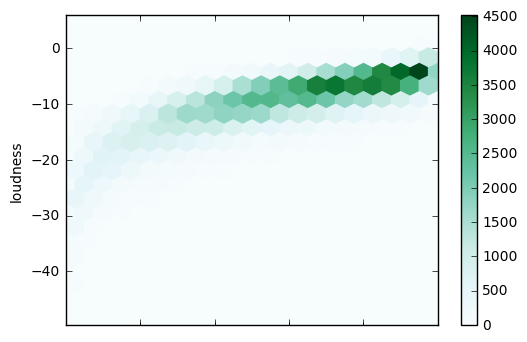

x-label: energy


In [8]:
df[['danceability','energy']].plot(kind='Hexbin', x='danceability', y='energy', gridsize=20)
plt.xlabel('danceability')
plt.ylabel('energy')
plt.show()
print "x-label: danceability"

df[['danceability','valence']].plot(kind='Hexbin', x='danceability', y='valence', gridsize=20)
plt.xlabel('danceability')
plt.ylabel('valence')
plt.show()
print "x-label: danceability"

df[['danceability','tempo']].plot(kind='Hexbin', x='danceability', y='tempo', gridsize=20)
plt.xlabel('danceability')
plt.ylabel('tempo')
plt.show()
print "x-label: danceability"

df[['energy','loudness']].plot(kind='Hexbin', x='energy', y='loudness', gridsize=20)
plt.xlabel('energy')
plt.ylabel('loudness')
plt.show()
print "x-label: energy"

Use the following code if you wish to see all 136 plots generated (except for those features which would not make sense, such as track id).

In [9]:
# for i, item in enumerate(combinations(feature_cols+general_cols,2)):
#     try:
#         df[list(item)].plot(kind='Hexbin', x=item[0], y=item[1], gridsize=20)
#         plt.xlabel(item[0])
#         plt.ylabel(item[1])
#         plt.show()
#         print i, item
#     except:
#         print i, item, "Plot failed"
#         continue

## Machine Learning Prediction

We now apply some machine learning techniques to try to predict genre based on audio features. 
To do this, we exclude all non-trainable columns from our data, such as track id and name.

We begin our global analysis with trees, since these are relatively powerful for being easy to interpret.

### Trees
After importing the requisite packages, we eliminate unneccesary columns and perform a test-training split.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [11]:
# Remove unneccesary columns
trainable_cols = ['danceability','energy','key','loudness',
                    'mode','speechiness','acousticness',
                    'instrumentalness','liveness','valence',
                    'tempo','duration_ms','time_signature']

# Perform a test-training split
train_x, test_x, train_y, test_y = train_test_split(df[trainable_cols], df['genre'],train_size=0.7)

We now test the default Decision Tree Classifier on a variety of maximum depths, finding the best depth to be 12:

In [12]:
# Perform the default Decision Tree Classification
for i in xrange(2,16):
    tree = DecisionTreeClassifier(max_depth=i)
    tree.fit(train_x, train_y)
    predictions = tree.predict(test_x)
    accuracy = np.mean(predictions==test_y)
    print "Accuracy rate:", accuracy, i

Accuracy rate: 0.0113721103654 2
Accuracy rate: 0.0168584212208 3
Accuracy rate: 0.025061254927 4
Accuracy rate: 0.0330776605944 5
Accuracy rate: 0.0433312027272 6
Accuracy rate: 0.0491637370832 7
Accuracy rate: 0.0553158623628 8
Accuracy rate: 0.0609619686801 9
Accuracy rate: 0.0657025673804 10
Accuracy rate: 0.0692180675402 11
Accuracy rate: 0.0699371471184 12
Accuracy rate: 0.0694843933099 13
Accuracy rate: 0.0675934803452 14
Accuracy rate: 0.0633322680303 15


Notice that our accuracies of predicting genre based on the gloabl audio features are quite low! However, even an accuracy of 1% is three times better than the base accuracy.

We find slightly better results by requiring the minimum number of samples per leaf to be 10:

In [13]:
# Perform the default Decision Tree Classification
tree = DecisionTreeClassifier(max_depth=12, min_samples_leaf=10)
tree.fit(train_x, train_y)
predictions = tree.predict(test_x)
accuracy = tree.score(test_x,test_y)
print "Accuracy rate:", accuracy

Accuracy rate: 0.0714818365825


### Random Forests
We now consider a random forest to try and improve our accuracy. We use the same constraints as for our last tree, since these are a marked improvement over the default classifiers:

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
# Perform the default Random Forest Classification
forest = RandomForestClassifier(max_depth=12, min_samples_leaf=10)
forest.fit(train_x, train_y)
accuracy = forest.score(test_x,test_y)
print "Accuracy rate:", accuracy

Accuracy rate: 0.0854639394908


Thus, classifying genre based on the global patterns of audio features is indeed a difficult problem due to the low correlations between songs. However, by using trees and random forests, we can predict genre with over .08 accuracy, which is significant improvement over the base accuracy of around .0035.

## Family-Based Prediction

We now explore how we can improve accuracy by looking at the patterns of clusters of genres, rather than global patterns.

In [16]:
df[df.genre.str.contains('Rock*')][:5]

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,ID_,duration_ms,time_signature,genre,artist,track
2762,0.310,0.700,9.0,-5.678,1.0,0.0470,0.011000,0.009650,0.0828,0.782,188.386,08mG3Y1vljYA6bvDt4Wqkj,255493.0,4.0,Album Rock,AC/DC,Back In Black
2763,0.573,0.913,6.0,-4.793,0.0,0.1320,0.059100,0.001730,0.1560,0.456,115.715,2zYzyRzz6pRmhPzyfMEC8s,208400.0,4.0,Album Rock,AC/DC,Highway to Hell
2764,0.501,0.889,4.0,-5.175,1.0,0.0364,0.000147,0.011400,0.2170,0.236,133.519,57bgtoPSgt236HzfBOd8kj,292880.0,4.0,Album Rock,AC/DC,Thunderstruck
2765,0.529,0.768,7.0,-5.510,1.0,0.0566,0.002240,0.000685,0.2970,0.769,127.316,6yl8Es1tCYD9WdSkeVLFw4,210880.0,4.0,Album Rock,AC/DC,You Shook Me All Night Long
2766,0.754,0.759,9.0,-5.218,1.0,0.3020,0.153000,0.000114,0.1010,0.449,126.367,7LRMbd3LEoV5wZJvXT1Lwb,214667.0,4.0,Album Rock,AC/DC,T.N.T.


In [17]:
genre_list = list(set(df['genre']))

From a quick examination of the dataframe we see that of our starting 944 genres most were empty, leaving us with 285 genres. We hypothesize that if we break up our classification into two parts we can increase our predictive accuracy. First, we will identify major families of genre, like Rock, and then we will try to identify the track's sub-genre within its family.

In [18]:
#create a Dataframe of the genres to create lists of Genre-Families
genre_df = pd.DataFrame(genre_list)
genre_df[:5]

,0
0,Country-Rock
1,Mbalax
2,Gamelan
3,Lo-Fi
4,Brill Building Pop


Below is an example of one of the several Families.

### Exploring the Families of Genre

In [19]:
#extract the 'Rock' family
print genre_df[genre_df[0].str.contains('Rock')][:5]

print genre_df[genre_df[0].str.contains('Pop')][:5]

                0
0    Country-Rock
9   Southern Rock
22     Indie Rock
26      Glam Rock
35     Roots Rock
                     0
4   Brill Building Pop
34       Taiwanese Pop
53           AustroPop
55           Latin Pop
62            Twee Pop


### Creating a Two Step Classifier

In [20]:
#Create Several families based on Observation
genre_pop         = genre_df[genre_df[0].str.contains('Pop')][0].tolist()
genre_rock        = genre_df[genre_df[0].str.contains('Rock')][0].tolist()
genre_dance       = genre_df[genre_df[0].str.contains('Dance')][0].tolist()
genre_blues       = genre_df[genre_df[0].str.contains('Blues')][0].tolist()
genre_punk        = genre_df[genre_df[0].str.contains('Punk')][0].tolist()
genre_jazz        = genre_df[genre_df[0].str.contains('Jazz')][0].tolist()
genre_country     = genre_df[genre_df[0].str.contains('Country')][0].tolist()


#assmeble the Families for later iteration
family_names  = ['Pop','Rock','Dance','Blues','Punk','Jazz','Country','Progressive','Metal','Other'] 
families_sub  = [genre_pop, genre_rock, genre_dance, genre_blues,
                 genre_punk, genre_jazz, genre_country]

You'll notice that this list is neither mutually exclusive or collectively exhaustive. There are some genres that are singular and there are some genres that are hybrids between major families where it is useful to have them in both families, where it is useful for it to be in both. We will now create several dataframes, one per familiy and a miscellaneous catch-all. Before that though we must make a dataframe that has been re-labelled by family. Due to the overlapping nature of certain families we will add in a duplicate row for a data, one per additional family it is a constituent of.

In [21]:
pop_df     = df[df.genre.isin(families_sub[0])]
rock_df    = df[df.genre.isin(families_sub[1])]
dance_df   = df[df.genre.isin(families_sub[2])]
blues_df   = df[df.genre.isin(families_sub[3])]
punk_df    = df[df.genre.isin(families_sub[4])]
jazz_df    = df[df.genre.isin(families_sub[5])]
country_df = df[df.genre.isin(families_sub[6])]


other_df = df[-df.genre.isin(sum(families_sub, []))]


### Visualizing the Families

We will examine two family to illustrate the differences between them

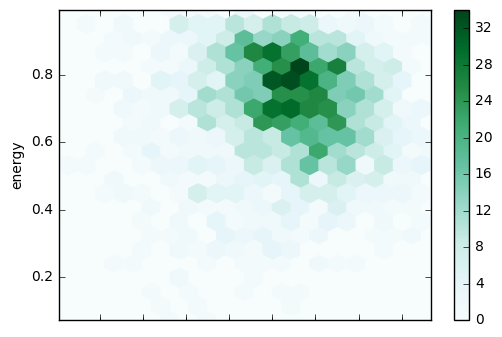

x-label: danceability, Genre: Dance


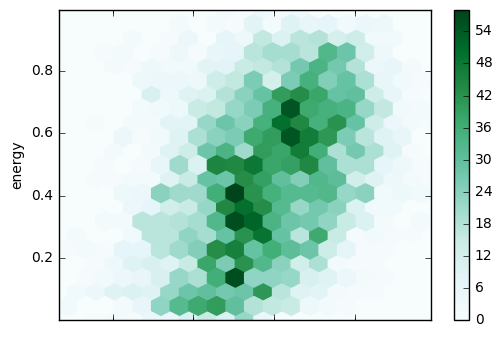

x-label: danceability, Genre: Jazz


In [22]:
dance_df[['danceability','energy']].plot(kind='Hexbin', x='danceability', y='energy', gridsize=20)
plt.xlabel('danceability')
plt.ylabel('energy')
plt.show()
print "x-label: danceability, Genre: Dance"

jazz_df[['danceability','energy']].plot(kind='Hexbin', x='danceability', y='energy', gridsize=20)
plt.xlabel('danceability')
plt.ylabel('energy')
plt.show()
print "x-label: danceability, Genre: Jazz"


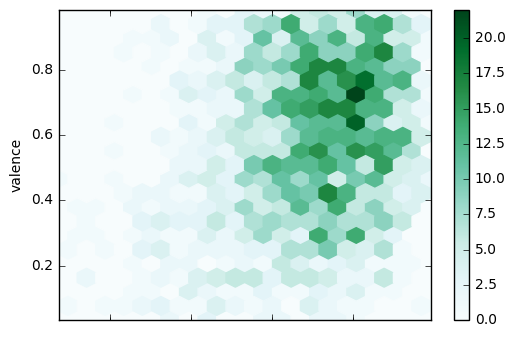

x-label: energy, Genre: Dance


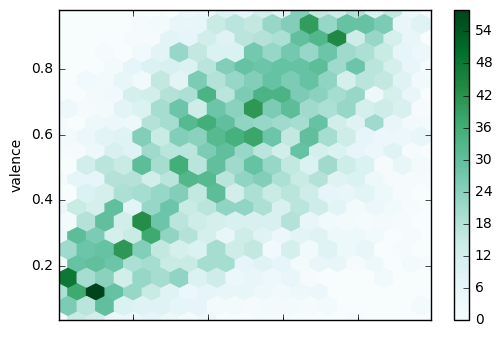

x-label: energy, Genre: Jazz


In [23]:

dance_df[['energy','valence']].plot(kind='Hexbin', x='energy', y='valence', gridsize=20)
plt.xlabel('danceability')
plt.ylabel('valence')
plt.show()
print "x-label: energy, Genre: Dance"

jazz_df[['energy','valence']].plot(kind='Hexbin', x='energy', y='valence', gridsize=20)
plt.xlabel('danceability')
plt.ylabel('valence')
plt.show()
print "x-label: energy, Genre: Jazz"


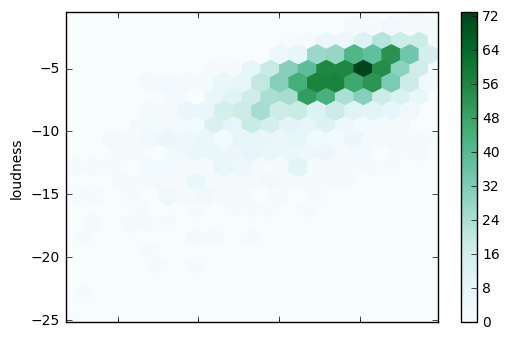

x-label: energy, Genre: Dance


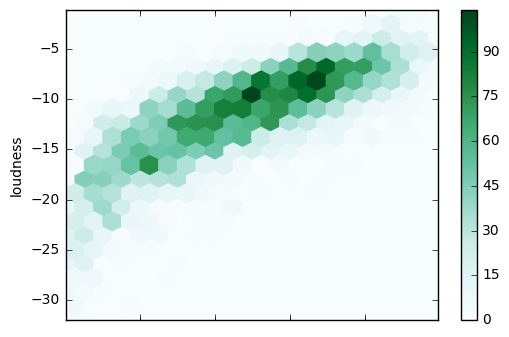

x-label: energy, Genre: Jazz


In [24]:

dance_df[['energy','loudness']].plot(kind='Hexbin', x='energy', y='loudness', gridsize=20)
plt.xlabel('energy')
plt.ylabel('loudness')
plt.show()
print "x-label: energy, Genre: Dance"

jazz_df[['energy','loudness']].plot(kind='Hexbin', x='energy', y='loudness', gridsize=20)
plt.xlabel('energy')
plt.ylabel('loudness')
plt.show()
print "x-label: energy, Genre: Jazz"

From the series of plots above it is clear that the different families have wildly different attributes. Which should help make them simpler to classify against than the all the sub genres next to each other.

#### Build the Dataframes

In [25]:

family_df = pd.DataFrame()

# get a list of dataframes to copy and append bc pandas doesn't like concatenating
# slices of dataframes with replaced values
dataframes = [pop_df,rock_df,dance_df,blues_df,punk_df,jazz_df,country_df,other_df]

#this is a really messy way to do this but it works
counter = 0

for frame in dataframes:
    copy = frame.copy()
    copy.genre = family_names[counter]

    family_df = pd.concat([family_df,copy])
    
    counter += 1
    

Now that we have a dataframe based only on family classifiers let's see how accurate it is at identifying the family of a song using a decision tree.

### Decision Tree Classifier

In [26]:
# Remove unneccesary columns
trainable_cols = ['danceability','energy','key','loudness',
                    'mode','speechiness','acousticness',
                    'instrumentalness','liveness','valence',
                    'tempo','duration_ms','time_signature']

# Perform a test-training split
train_x, test_x, train_y, test_y = train_test_split(family_df[trainable_cols], family_df['genre'],train_size=0.7)

In [27]:
# Perform the default Decision Tree Classification
fam_tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=3)
fam_tree.fit(train_x, train_y)
predictions = fam_tree.predict(test_x)
accuracy = fam_tree.score(test_x,test_y)
print "Family Accuracy rate:", accuracy

Family Accuracy rate: 0.655540066088


Now that we have a family classifier let's build the individual genre trees and run the data through there to see what our accuracy is. 

#### Subgenre Classification

In [28]:

# Perform a test-training split
train_x, test_x, train_y, test_y = train_test_split(pop_df[trainable_cols], pop_df['genre'],train_size=0.8)

# Perform the default Decision Tree Classification
pop_tree = DecisionTreeClassifier(max_depth=9, min_samples_leaf=9)
pop_tree.fit(train_x, train_y)
predictions = pop_tree.predict(test_x)
accuracy = pop_tree.score(test_x,test_y)
print "Pop Accuracy rate:", accuracy

Pop Accuracy rate: 0.173575129534


In [29]:

# Perform a test-training split
train_x, test_x, train_y, test_y = train_test_split(rock_df[trainable_cols], rock_df['genre'],train_size=0.8)

# Perform the default Decision Tree Classification
rock_tree = DecisionTreeClassifier(max_depth=9, min_samples_leaf=9)
rock_tree.fit(train_x, train_y)
predictions = rock_tree.predict(test_x)
accuracy = rock_tree.score(test_x,test_y)
print "Rock Accuracy rate:", accuracy

Rock Accuracy rate: 0.177471264368


In [30]:

# Perform a test-training split
train_x, test_x, train_y, test_y = train_test_split(dance_df[trainable_cols], dance_df['genre'],train_size=0.8)

# Perform the default Decision Tree Classification
dance_tree = DecisionTreeClassifier(max_depth=9, min_samples_leaf=9)
dance_tree.fit(train_x, train_y)
predictions = dance_tree.predict(test_x)
accuracy = dance_tree.score(test_x,test_y)
print "Dance Accuracy rate:", accuracy

Dance Accuracy rate: 0.526992287918


#### Non-familied Genre Classification

In [31]:

# Perform a test-training split
train_x, test_x, train_y, test_y = train_test_split(other_df[trainable_cols], other_df['genre'],train_size=0.8)

# Perform the default Decision Tree Classification
rock_tree = DecisionTreeClassifier(max_depth=9, min_samples_leaf=9)
rock_tree.fit(train_x, train_y)
predictions = rock_tree.predict(test_x)
accuracy = rock_tree.score(test_x,test_y)
print "Other Accuracy rate:", accuracy

Other Accuracy rate: 0.0866188066376


### Random Forest

#### Family Classification

In [32]:
# Perform a test-training split
train_x, test_x, train_y, test_y = train_test_split(family_df[trainable_cols], family_df['genre'],train_size=0.7)

# Perform the default Random Forest Classification
forest = RandomForestClassifier(criterion = 'gini',max_features=5, min_samples_leaf=5, n_estimators = 20)
forest.fit(train_x, train_y)
accuracy = forest.score(test_x,test_y)
print "Family Accuracy rate:", accuracy

Family Accuracy rate: 0.687577447336


Now that we have our Random Forest Family Classifier, let's build the random forest sub genre trees and see how well they run.

#### Subgenre Classification

In [33]:
# Perform a test-training split
train_x, test_x, train_y, test_y = train_test_split(pop_df[trainable_cols], pop_df['genre'],train_size=0.7)

# Perform the default Random Forest Classification
forest = RandomForestClassifier(criterion = 'gini',max_features=5, min_samples_leaf=5, n_estimators = 20)
forest.fit(train_x, train_y)
accuracy = forest.score(test_x,test_y)
print "Pop Accuracy rate:", accuracy

Pop Accuracy rate: 0.2130109384


In [34]:
# Perform a test-training split
train_x, test_x, train_y, test_y = train_test_split(rock_df[trainable_cols], rock_df['genre'],train_size=0.9)

# Perform the default Random Forest Classification
forest = RandomForestClassifier(criterion = 'gini',max_features=5, min_samples_leaf=5, n_estimators = 20)
forest.fit(train_x, train_y)
accuracy = forest.score(test_x,test_y)
print "Rock Accuracy rate:", accuracy

Rock Accuracy rate: 0.199448529412


In [35]:
# Perform a test-training split
train_x, test_x, train_y, test_y = train_test_split(jazz_df[trainable_cols], jazz_df['genre'],train_size=0.7)

# Perform the default Random Forest Classification
forest = RandomForestClassifier(criterion = 'gini',max_features=5, min_samples_leaf=5, n_estimators = 20)
forest.fit(train_x, train_y)
accuracy = forest.score(test_x,test_y)
print "Jazz Accuracy rate:", accuracy

Jazz Accuracy rate: 0.264904386952


In [36]:
# Perform a test-training split
train_x, test_x, train_y, test_y = train_test_split(dance_df[trainable_cols], dance_df['genre'],train_size=0.7)

# Perform the default Random Forest Classification
forest = RandomForestClassifier(criterion = 'gini',max_features=5, min_samples_leaf=5, n_estimators = 20)
forest.fit(train_x, train_y)
accuracy = forest.score(test_x,test_y)
print "Dance Accuracy rate:", accuracy

Dance Accuracy rate: 0.630136986301


In [38]:
# Perform a test-training split
train_x, test_x, train_y, test_y = train_test_split(other_df[trainable_cols], other_df['genre'],train_size=0.7)

# Perform the default Random Forest Classification
forest = RandomForestClassifier(criterion = 'gini',max_features=5, min_samples_leaf=5, n_estimators = 20)
forest.fit(train_x, train_y)
accuracy = forest.score(test_x,test_y)
print "Other Accuracy rate:", accuracy

Other Accuracy rate: 0.123808402966
